<a href="https://colab.research.google.com/github/Sumanth-Katnam/CSE594/blob/main/test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load data from CSV


In [ ]:
import pandas as pd
from avro.datafile import DataFileReader
from avro.io import DatumReader

filename_txt = 'D:/Work/PSU/Summer 2022/CSE 594/Github/BCPG-Alpha/nn_preprocess/trial.avro'
avro_records = []
with open(filename_txt, 'rb') as f:
    reader = DataFileReader(f, DatumReader())
    avro_records = [rec for rec in reader]
    reader.close()

df = pd.DataFrame(avro_records)

In [ ]:
import pandas as pd

# dataset = pd.read_csv('trial.csv') #55765 excel #46711 ++
dataset = pd.read_csv('sat_temp.csv') 
dataset['cnf'] = dataset['cnf'].astype('string')
dataset['label'] = dataset['label'].astype('int')
print('Total: ', dataset.shape)

Total:  (70, 2)


In [ ]:
dataset.head()

,cnf,label
0,( -142 V -1483 ) ^ ( 144 V -1483 ) ^ ( -145 V ...,1
1,( -1482 V 373 V 375 V 377 V -1484 V 417 V 419 ...,1
2,( -1488 V 1489 ) ^ ( 377 V 1488 V -1489 ) ^ ( ...,1
3,( -1489 V -1491 V 417 V 419 V 421 V 1492 ) ^ (...,1
4,( -174 V -1494 ) ^ ( -3 V -16 V -17 V -59 V 78...,1


In [ ]:
#TODO: Split 80-20
train_df, test_df = dataset.iloc[0:dataset.shape[0]-9], dataset[dataset.shape[0]-9:]
test_df.reset_index(drop=True, inplace=True)

print("Rows in test: %s " % len(test_df))
print("Rows in train: %s " % len(train_df))

Rows in test: 9 
Rows in train: 61 


In [ ]:
train_df.head(5)

,cnf,label
0,( -142 V -1483 ) ^ ( 144 V -1483 ) ^ ( -145 V ...,1
1,( -1482 V 373 V 375 V 377 V -1484 V 417 V 419 ...,1
2,( -1488 V 1489 ) ^ ( 377 V 1488 V -1489 ) ^ ( ...,1
3,( -1489 V -1491 V 417 V 419 V 421 V 1492 ) ^ (...,1
4,( -174 V -1494 ) ^ ( -3 V -16 V -17 V -59 V 78...,1


# Imports

In [ ]:
import torch
import torch.nn as nn
import math
import random
import string
import time
import matplotlib.pyplot as plt

%matplotlib inline

# Preparing Data

In [ ]:
# Generate a list of tuples (title, label) for each data row
def read_data(dataframe):
    df = dataframe[['cnf', 'label']]
    df = df.dropna(subset=['cnf', 'label'])
    return [tuple(x) for x in df.to_numpy()]


def random_training_pair(pairs):
    rand_index = random.randint(0, len(pairs) - 1)
    return pairs[rand_index]

# Establish Tensors

In [ ]:
all_characters = string.printable
n_characters = len(all_characters)

In [ ]:
# Turns line into <line_length x 1 x n_letters> tensor
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_characters)
    for li, letter in enumerate(line):
        tensor[li][0][all_characters.find(letter)] = 1
    return tensor

# Turns label into <1 x 1> tensor
def label_to_tensor(label):
    return torch.tensor([label], dtype=torch.long)

# Create Network

In [ ]:
class RNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassify, self).__init__()

        self.hidden_size = hidden_size
        
        # Initialize linear and softmax layers
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden=None):
        # Concatenate input tensor and hidden state
        combined = torch.cat((input, hidden), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


# Takes the category with the highest probability as a guess
def category_from_output(output):
    top_n, top_i = output.topk(1)
    return top_i[0].item()

# Train Network

500 10% (1m 18s) 0.6917 ( -215 V -1458 ) ^ ( 353 V -1458 ) ^ ( 82 V -1458 ) ^ ( -102 V -1458 ) ^ ( -111 V -1458 ) ^ ( -120 V -1458 ) ^ ( -129 V -1458 ) ^ ( -4 V -19 V -20 V -59 V 78 V 215 V -353 V -82 V 102 V 111 V 120 V 129 V 1458 ) ^ ( -1380 V -357 V 1459 ) ^ ( 1380 V -357 V -1459 ) ^ ( -1458 V 357 V 1459 ) ^ ( 1458 V 357 V -1459 ) ^ ( 1459 V -1460 ) ^ ( -364 V -1460 ) ^ ( -366 V -1460 ) ^ ( -368 V -1460 ) ^ ( 1384 V -1460 ) ^ ( -408 V -1460 ) ^ ( -410 V -1460 ) ^ ( -412 V -1460 ) ✓
1000 20% (2m 36s) 0.7089 ( -637 V -1390 ) ^ ( -657 V -1390 ) ^ ( -676 V -1390 ) ^ ( -704 V -1390 ) ^ ( -724 V -1390 ) ^ ( -743 V -1390 ) ^ ( 216 V 218 V -338 V 274 V 276 V 278 V 327 V 329 V 331 V 637 V 657 V 676 V 704 V 724 V 743 V 1390 ) ^ ( -216 V -1391 ) ^ ( -218 V -1391 ) ^ ( 338 V -1391 ) ^ ( -274 V -1391 ) ^ ( -276 V -1391 ) ^ ( -278 V -1391 ) ^ ( -327 V -1391 ) ^ ( -329 V -1391 ) ^ ( -331 V -1391 ) ^ ( 216 V 218 V -338 V 274 V 276 V 278 V 327 V 329 V 331 V 1391 ) ^ ( 29 V -1392 ) ^ ( 30 V -1392 ) ✗

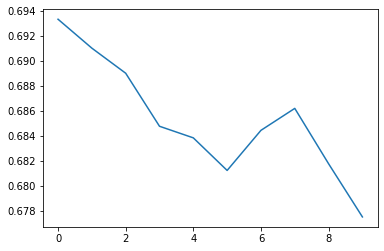

In [ ]:
# Helper function to display how long the training has been running
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


# Creates function that performs a step in the training loop
def make_train_step(model, criterion, optimizer):
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        
        # Initialize hidden state
        hidden = model.init_hidden()

        # Makes predictions, running through each letter tensor
        for i in range(x.size()[0]):
            output, hidden = model(x[i], hidden)

        # Computes loss
        loss = criterion(output, y)

        # Computes gradients
        loss.backward()

        # Updates parameters
        optimizer.step()
        optimizer.zero_grad()

        return output, loss.item()

    return train_step

# Run training on a given dataframe
def run(train_df, plot=False):
    n_iters = 5000
    print_every = 500
    plot_every = 500
    hidden_len = 64

    current_loss = 0
    all_losses = []

    model = RNNClassify(n_characters, hidden_len, 2)
    data_tuples = read_data(train_df)

    # Create the optimizer and loss function (criterion)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
    criterion = nn.NLLLoss()

    train_step = make_train_step(model, criterion, optimizer)

    start = time.time()
    
    for i in range(1, n_iters + 1):
        # Get data and turn input/target into tensors
        title, label = random_training_pair(data_tuples)
        input_tensor = line_to_tensor(title)
        target_tensor = label_to_tensor(label)

        # Run one training step
        output, loss = train_step(input_tensor, target_tensor)

        # The rest of the code in this function is to show how
        # the network is learning
        current_loss += loss

        if i % print_every == 0:
            guess = category_from_output(output)
            correct = '✓' if label == guess else '✗'
            print('%d %d%% (%s) %.4f %s %s' % (i, i / n_iters * 100, time_since(start), loss, title, correct))
        
        if i % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

    if plot:
        plt.figure()
        plt.plot(all_losses)

    # Save the model
    torch.save(model.state_dict(), "test.model")

run(train_df, plot=True)

# Evaluate Model

In [ ]:
# Predict the label given a title
def evaluate(title, model):
    model.eval()
    hidden = model.init_hidden()
    input_tensor = line_to_tensor(title)
    for i in range(input_tensor.size()[0]):
        output, hidden = model(input_tensor[i], hidden)
    return category_from_output(output)

# Calculate accuracy, recall, and precision on a given test dataframe
def calculate_accuracy(model, test_df):
    false_positives = 0
    false_negatives = 0
    true_positives = 0
    true_negatives = 0

    tuples = read_data(test_df)
    for title, label in tuples:
        prediction = evaluate(title, model)
        if label == prediction and label:
            true_positives += 1
        if label == prediction and not label:
            true_negatives += 1
        if label != prediction and label:
            false_negatives += 1
        if label != prediction and not label:
            false_positives += 1
    accuracy = (true_positives + true_negatives) / len(test_df)
    recall = true_positives / (true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)
    return accuracy, recall, precision

(1.0, 1.0, 1.0)

In [ ]:
model = RNNClassify(n_characters, 64, 2)
model.load_state_dict(torch.load('test.model'))
calculate_accuracy(model, test_df)

(0.7777777777777778, 1.0, 0.7777777777777778)